# Model fitting 2: SSC + galaxy template

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.7/site-packages/jetset-1.1.2-py3.7-macosx-10.9-x86_64.egg/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.7/site-packages/jetset-1.1.2-py3.7-macosx-10.9-x86_64.egg/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.7/site-packages/jetset-1.1.2-py3.7-macosx-10.9-x86_64.egg/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [3]:
data=Data.from_file(test_SEDs[2])



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



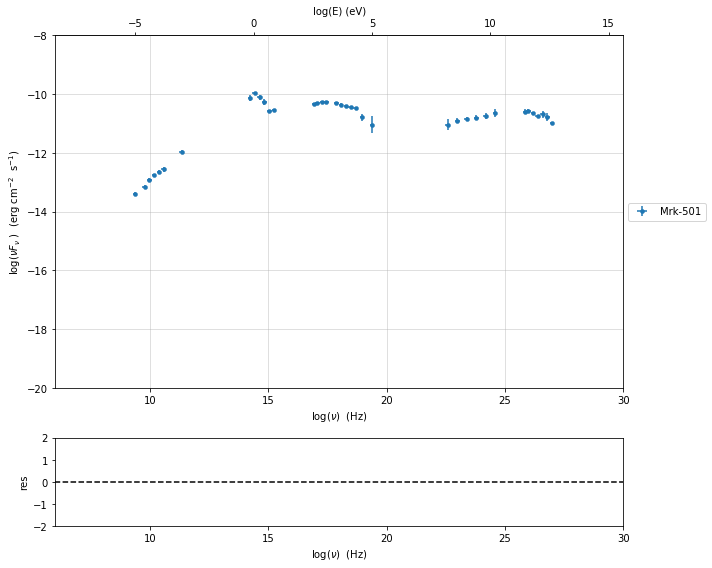

In [4]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [7]:
sed_data.save('Mrk_501.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



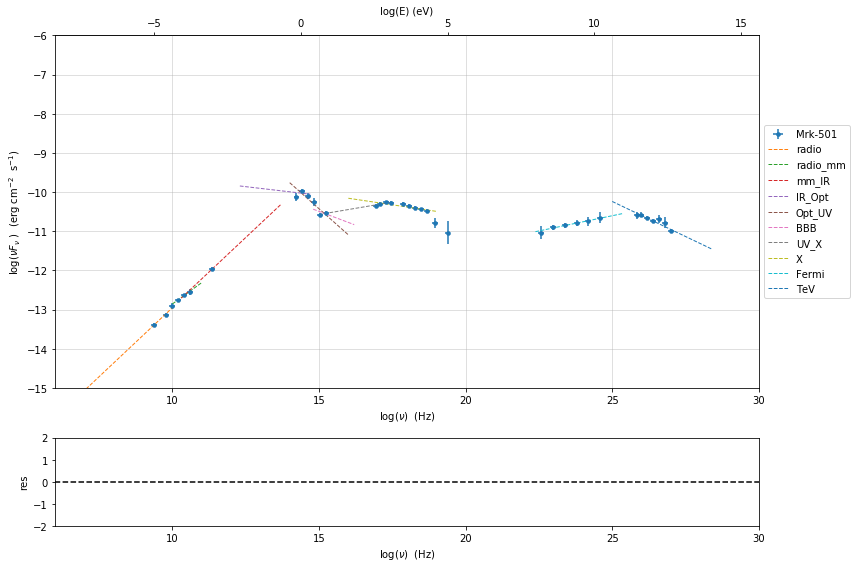

In [5]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

### Sed shaper

In [47]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10. , 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP


 model name     name      bestfit val     err +     err -   start val   fit range min fit range max frozen
----------- ------------ ------------- ------------ ----- ------------- ------------- ------------- ------
   LogCubic            b -6.411144e-02 7.838941e-03    -- -4.778766e-02 -1.000000e+01  0.000000e+00  False
   LogCubic            c -1.751706e-03 1.127019e-03    --  3.576198e-03 -1.000000e+01  1.000000e+01  False
   LogCubic           Ep  1.703747e+01 9.437328e-02    --  1.626870e+01  0.000000e+00  3.000000e+01  False
   LogCubic           Sp -1.030068e+01 1.884113e-02    -- -1.025412e+01 -3.000000e+01  0.000000e+00  False
host_galaxy nuFnu_p_host -1.006556e+01 5.462496e-02    -- -1.025412e+01 -1.225412e+01 -8.254123e+00  False
host_galaxy     nu_scale  1.730750e-02 3.694862e-03    --  0.000000e+00 -5.000000e-01  5.000000e-01  F


*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit


model name name  bestfit val     err +     err -   start val   fit range min fit range max frozen
---------- ---- ------------- ------------ ----- ------------- ------------- ------------- ------
  LogCubic    b -1.310958e-01 3.244105e-02    -- -1.000000e+00 -1.000000e+01  0.000000e+00  False
  LogCubic    c -3.300308e-02 2.072526e-02    -- -1.000000e+00 -1.000000e+01  1.000000e+01  False
  LogCubic   Ep  2.549604e+01 2.235559e-01    --  2.556357e+01  0.000000e+00  3.000000e+01  False
  LogCubic   Sp -1.057946e+01 4.333061e-02    -- -1.000000e+01 -3.000000e+01  0.000000e+00  False
---> IC         nu_p=+2.549604e+01 (err=+2.235559e-01)  nuFnu_p=-1.057946e+01 (err=+4.333061e-02) curv.=-1.310958e-01 (err=+3.244105e-02)



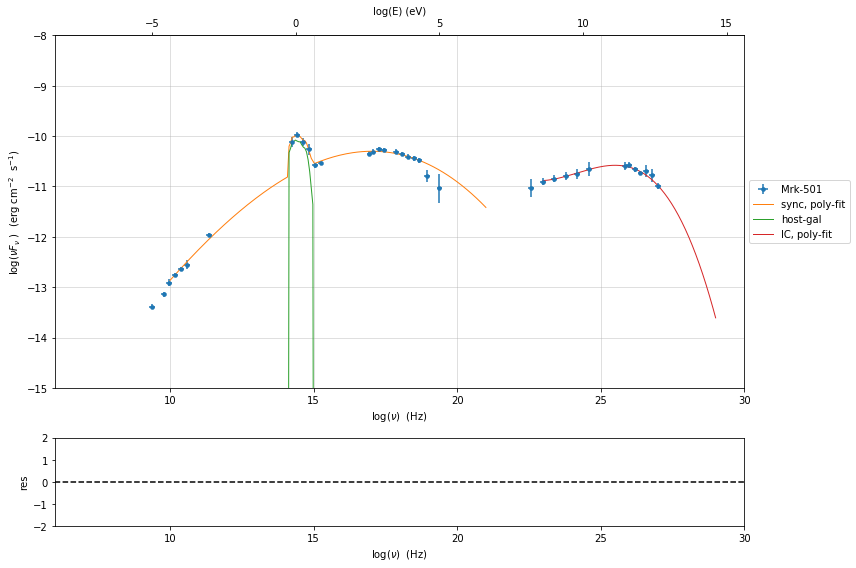

In [24]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [25]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_gal_templ.pkl')


***  constrains parameters from observable ***

      name             par type           units          val      phys. bound. min phys. bound. max  log  frozen
---------------- ------------------- --------------- ------------ ---------------- ---------------- ----- ------
            gmin  low-energy-cut-off lorentz-factor* 1.057074e+02     1.000000e+00     1.000000e+09 False  False
            gmax high-energy-cut-off lorentz-factor* 1.642067e+06     1.000000e+00     1.000000e+15 False  False
               N    emitters_density         1 / cm3 1.078494e+02     0.000000e+00               -- False  False
               s   LE_spectral_slope                 2.248787e+00    -1.000000e+01     1.000000e+01 False  False
               r  spectral_curvature                 3.205572e-01    -1.500000e+01     1.500000e+01 False  False
gamma0_log_parab    turn-over-energy lorentz-factor* 7.432066e+03     1.000000e+00     1.000000e+09 False  False
               R         region_size           

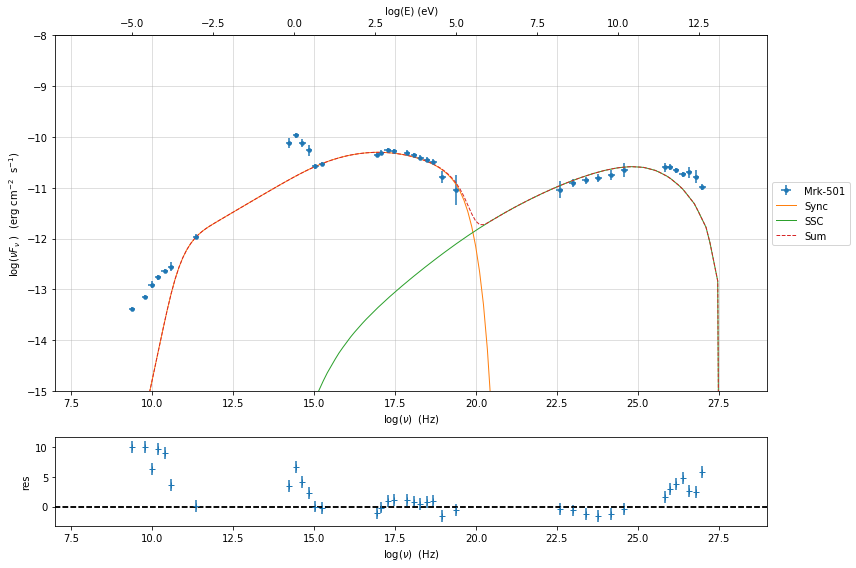

In [26]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

## Model fitting

### Model fitting with LSB

In [27]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)

      name             par type           units          val      phys. bound. min phys. bound. max  log  frozen
---------------- ------------------- --------------- ------------ ---------------- ---------------- ----- ------
            gmin  low-energy-cut-off lorentz-factor* 1.057074e+02     1.000000e+00     1.000000e+09 False  False
            gmax high-energy-cut-off lorentz-factor* 1.642067e+06     1.000000e+00     1.000000e+15 False  False
               N    emitters_density         1 / cm3 1.078494e+02     0.000000e+00               -- False  False
               s   LE_spectral_slope                 2.248787e+00    -1.000000e+01     1.000000e+01 False  False
               r  spectral_curvature                 3.205572e-01    -1.500000e+01     1.500000e+01 False  False
gamma0_log_parab    turn-over-energy lorentz-factor* 7.432066e+03     1.000000e+00     1.000000e+09 False  False
               R         region_size              cm 5.485641e+15     1.000000e+03     1.000000e

In [28]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 
fit_model_lsb.show_model()


-------------------------------------------------------------------------------------------------------------------
Composite model description
-------------------------------------------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

-------------------------------------------------------------------------------------------------------------------
individual component description


-------------------------------------------------------------------------------------------------------------------
jet model description
-------------------------------------------------------------------------------------------------------------------
name: jet_leptonic  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 1.057074e+02
 gmax grid : 1.642067e+06
 normalization  True
 log-values 

In [48]:
fit_model_lsb.composite_expr='jet_leptonic + host_galaxy '

In [31]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [32]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3)

In [34]:
best_fit_lsb.save_report('SSC-best-fit-lsb.txt')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

best_fit_lsb.bestfit_table

model name,name,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.057901e+01,3.252862e+01,--,1.057074e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.923426e+06,1.035137e+06,--,1.642067e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,3.428342e+01,7.360941e+01,--,1.078494e+02,0.000000e+00,--,False
jet_leptonic,s,2.152853e+00,1.727103e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.185727e-01,4.325600e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,gamma0_log_parab,4.075417e+03,6.027271e+03,--,7.432066e+03,1.000000e+00,1.000000e+09,False
jet_leptonic,R,1.092028e+16,1.633182e+16,--,5.485641e+15,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.266761e-02,6.966549e-03,--,1.000000e-01,0.000000e+00,--,False


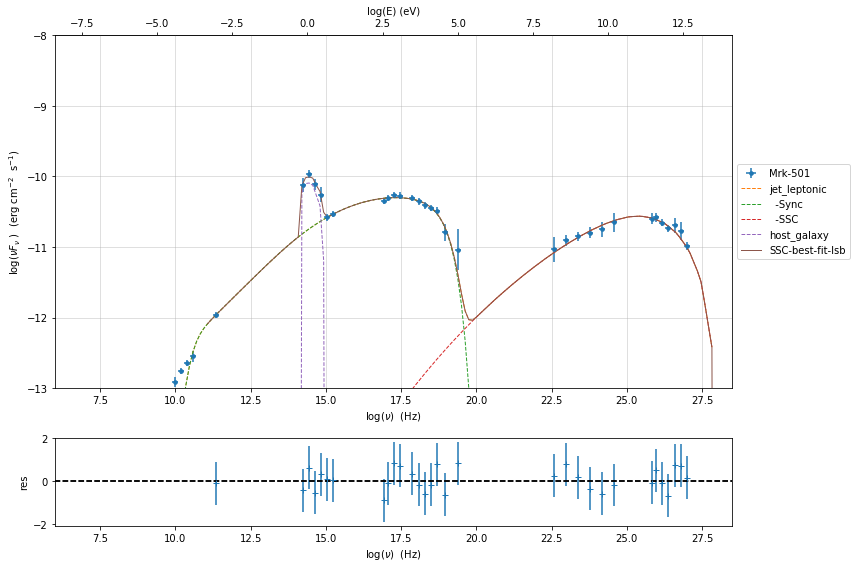

In [35]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

### Model fitting with Minuit

In [45]:
jet_minuit=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_minuit.set_gamma_grid_size(200)

      name             par type           units          val      phys. bound. min phys. bound. max  log  frozen
---------------- ------------------- --------------- ------------ ---------------- ---------------- ----- ------
            gmin  low-energy-cut-off lorentz-factor* 1.057074e+02     1.000000e+00     1.000000e+09 False  False
            gmax high-energy-cut-off lorentz-factor* 1.642067e+06     1.000000e+00     1.000000e+15 False  False
               N    emitters_density         1 / cm3 1.078494e+02     0.000000e+00               -- False  False
               s   LE_spectral_slope                 2.248787e+00    -1.000000e+01     1.000000e+01 False  False
               r  spectral_curvature                 3.205572e-01    -1.500000e+01     1.500000e+01 False  False
gamma0_log_parab    turn-over-energy lorentz-factor* 7.432066e+03     1.000000e+00     1.000000e+09 False  False
               R         region_size              cm 5.485641e+15     1.000000e+03     1.000000e

In [46]:
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=my_shape.host_gal) 
fit_model_minuit.show_model_components()
fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit.host_galaxy.parameters.nu_scale.frozen=True

model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-minuit',repeat=3)


-------------------------------------------------------------------------------------------------------------------
Composite model description
-------------------------------------------------------------------------------------------------------------------
name: SSC-best-fit-minuit  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

-------------------------------------------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0
| minim function calls=1010, chisq=16.080838 UL part=-0.0000002142684597977088.000000 UL part=-0.000000
fit run: 1
- minim function calls=140, chisq=16.289141 UL part=-0.000000
fit run: 2
| minim function calls=140, chisq=16.289141 UL part=-0.000000
*********************************************************************************************

In [47]:
model_minimizer_minuit.minimizer.mesg

------------------------------------------------------------------
| FCN = 16.08                   |     Ncalls=131 (142 total)     |
| EDM = 2.07E+04 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | par_0 |    88     |     9     |            |            |    1    |  1e+09  |       |
| 1 | par_1 |  0.995E9  |  0.002E9  |            |            |    1    |  1e+15  |       |
| 2 | par_2 |    65     |    21     |            |            |    0    |         |       |
| 3 | par_3 |   2.25    |   0.03    |            |            |   -10   |   10    |       |
| 4 | par_4 |   0.36    |   0.04    |            |            |   -15   |   15    |       |
| 5 | par_5 |   1.8E4   |   0.6E4   |            |            |    1    |  1e+09  |       |
| 6 | par_6 |  0.78E16  |  0.18E16  |            |            |3.16228e+15|3.16228e+17|       |
| 7 | par_7 |  1.91E-2  |  0.28E-2  |            |            |    0    |         |       |
| 8 | par_8 |    47     |     4     |            |            |    5    |   50    |       |
| 9 | par_9 |  -10.05   |    0.05   |            |            |-12.2541 |-8.25412 |       |
-------------------------------------------------------------------------------------------

for further informatio regardin minuit please refer to https://iminuit.readthedocs.io/en/latest/

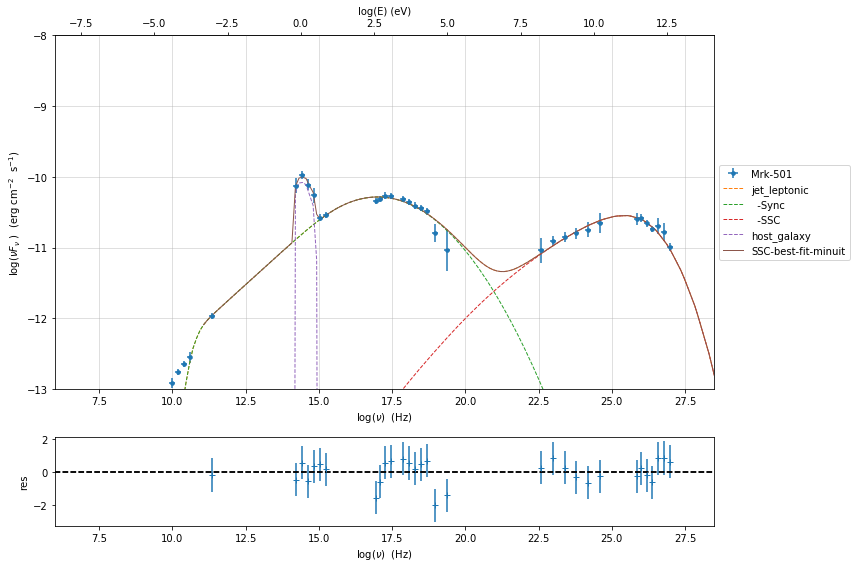

In [48]:
%matplotlib inline
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [49]:
best_fit_minuit.save_report('SSC-best-fit-minuit.txt')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

best_fit_lsb.bestfit_table

model name,name,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.057901e+01,3.252862e+01,--,1.057074e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.923426e+06,1.035137e+06,--,1.642067e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,3.428342e+01,7.360941e+01,--,1.078494e+02,0.000000e+00,--,False
jet_leptonic,s,2.152853e+00,1.727103e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.185727e-01,4.325600e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,gamma0_log_parab,4.075417e+03,6.027271e+03,--,7.432066e+03,1.000000e+00,1.000000e+09,False
jet_leptonic,R,1.092028e+16,1.633182e+16,--,5.485641e+15,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.266761e-02,6.966549e-03,--,1.000000e-01,0.000000e+00,--,False


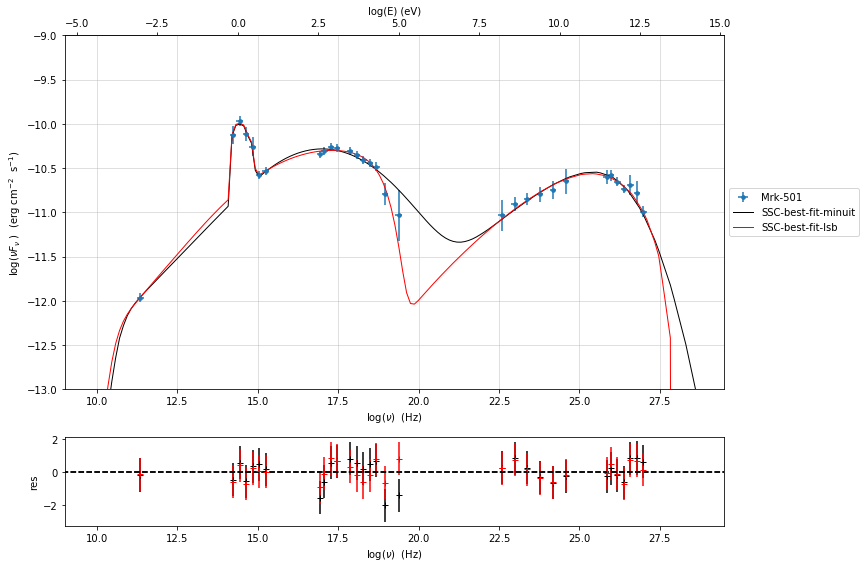

In [50]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 11., 29.])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 11., 29.],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 11., 29.],color='red')
p2.rescale(y_min=-13,y_max=-9,x_min=9,x_max=29.5)

### Model fitting with a bkn pl


In [51]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='bkn',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_bkn_gal_templ.pkl')


***  constrains parameters from observable ***

    name          par type           units          val      phys. bound. min phys. bound. max  log  frozen
----------- ------------------- --------------- ------------ ---------------- ---------------- ----- ------
       gmin  low-energy-cut-off lorentz-factor* 1.888625e+02     1.000000e+00     1.000000e+09 False  False
       gmax high-energy-cut-off lorentz-factor* 1.955869e+06     1.000000e+00     1.000000e+15 False  False
          N    emitters_density         1 / cm3 2.193451e+01     0.000000e+00               -- False  False
          p   LE_spectral_slope                 2.248787e+00    -1.000000e+01     1.000000e+01 False  False
        p_1   HE_spectral_slope                 3.500000e+00    -1.000000e+01     1.000000e+01 False  False
gamma_break    turn-over-energy lorentz-factor* 1.971879e+05     1.000000e+00     1.000000e+09 False  False
          R         region_size              cm 1.045240e+16     1.000000e+03     1.000

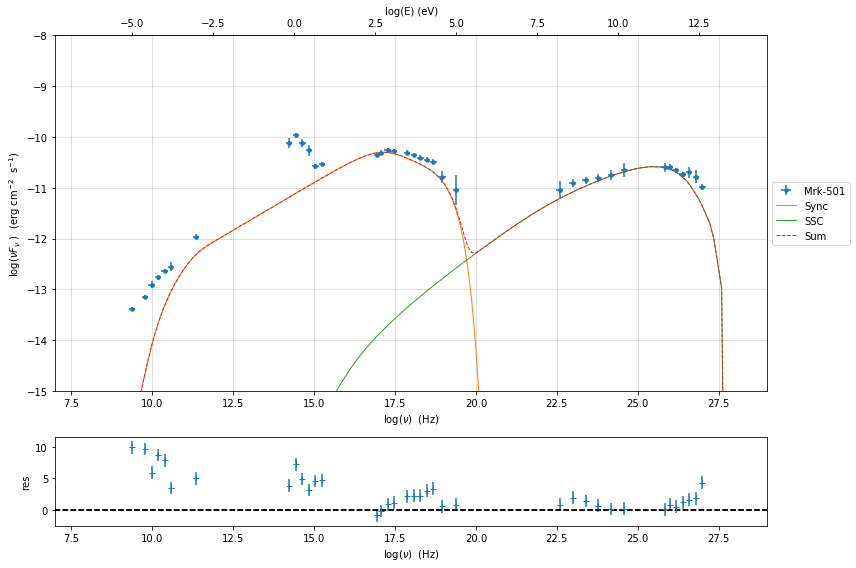

In [52]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

In [55]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)


fit_model_minuit_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-minuit-bkn',template=my_shape.host_gal) 
fit_model_minuit_bkn.show_model_components()
fit_model_minuit_bkn.freeze('jet_leptonic','z_cosm')
fit_model_minuit_bkn.freeze('jet_leptonic','R_H')
fit_model_minuit_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_minuit_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit_bkn.host_galaxy.parameters.nu_scale.frozen=True

model_minimizer_minuit_bkn=ModelMinimizer('minuit')
best_fit_minuit_bkn=model_minimizer_minuit.fit(fit_model_minuit_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit-bkn',repeat=3)

    name          par type           units          val      phys. bound. min phys. bound. max  log  frozen
----------- ------------------- --------------- ------------ ---------------- ---------------- ----- ------
       gmin  low-energy-cut-off lorentz-factor* 1.888625e+02     1.000000e+00     1.000000e+09 False  False
       gmax high-energy-cut-off lorentz-factor* 1.955869e+06     1.000000e+00     1.000000e+15 False  False
          N    emitters_density         1 / cm3 2.193451e+01     0.000000e+00               -- False  False
          p   LE_spectral_slope                 2.248787e+00    -1.000000e+01     1.000000e+01 False  False
        p_1   HE_spectral_slope                 3.500000e+00    -1.000000e+01     1.000000e+01 False  False
gamma_break    turn-over-energy lorentz-factor* 1.971879e+05     1.000000e+00     1.000000e+09 False  False
          R         region_size              cm 1.045240e+16     1.000000e+03     1.000000e+30 False  False
        R_H     region_posit

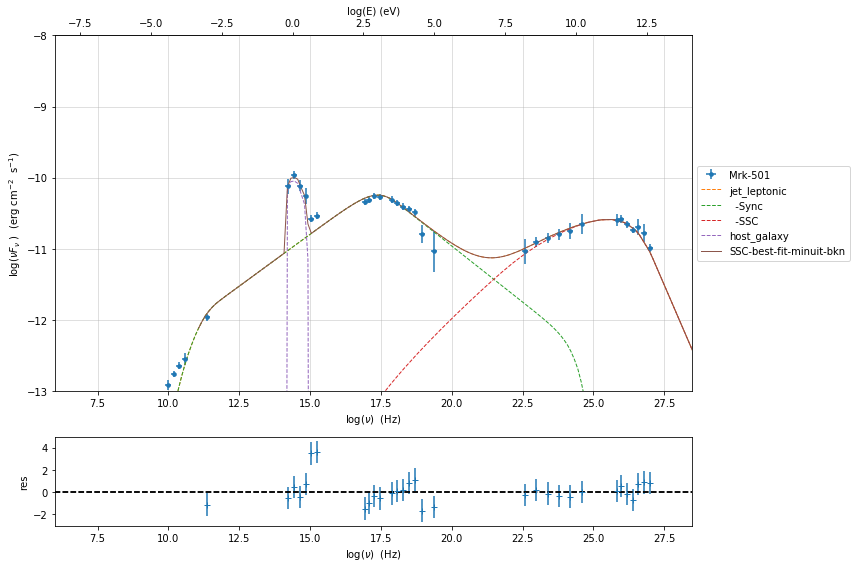

In [58]:
%matplotlib inline
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
p2=fit_model_minuit_bkn.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [60]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)

fit_model_lsb_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-bkn-lsb',template=my_shape.host_gal) 


fit_model_lsb_bkn.freeze(jet_lsb,'z_cosm')
fit_model_lsb_bkn.freeze(jet_lsb,'R_H')
fit_model_lsb_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_lsb_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb_bkn.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb_bkn.host_galaxy.parameters.nu_scale.frozen=True

model_minimizer_lsb_bkn=ModelMinimizer('lsb')
best_fit_lsb_bkn=model_minimizer_lsb_bkn.fit(fit_model_lsb_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-lsb',repeat=3)


    name          par type           units          val      phys. bound. min phys. bound. max  log  frozen
----------- ------------------- --------------- ------------ ---------------- ---------------- ----- ------
       gmin  low-energy-cut-off lorentz-factor* 1.888625e+02     1.000000e+00     1.000000e+09 False  False
       gmax high-energy-cut-off lorentz-factor* 1.955869e+06     1.000000e+00     1.000000e+15 False  False
          N    emitters_density         1 / cm3 2.193451e+01     0.000000e+00               -- False  False
          p   LE_spectral_slope                 2.248787e+00    -1.000000e+01     1.000000e+01 False  False
        p_1   HE_spectral_slope                 3.500000e+00    -1.000000e+01     1.000000e+01 False  False
gamma_break    turn-over-energy lorentz-factor* 1.971879e+05     1.000000e+00     1.000000e+09 False  False
          R         region_size              cm 1.045240e+16     1.000000e+03     1.000000e+30 False  False
        R_H     region_posit

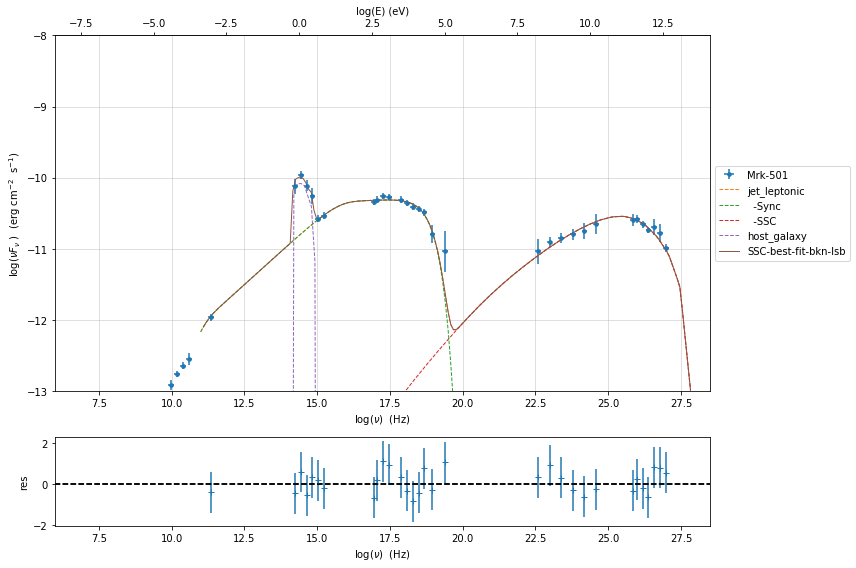

In [61]:
%matplotlib inline
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
p2=fit_model_lsb_bkn.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

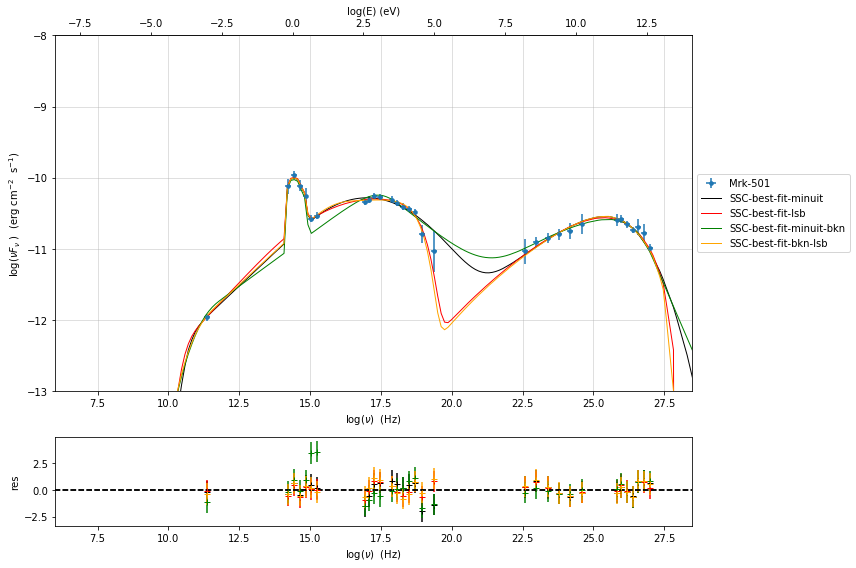

In [63]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 11., 29.])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 11. ,29.],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 11., 29.],color='red')
p2.add_model_plot(fit_model_minuit_bkn,color='green')
p2.add_residual_plot(fit_model_minuit_bkn,sed_data,fit_range=[ 11., 29.],color='green')
p2.add_model_plot(fit_model_lsb_bkn,color='orange')
p2.add_residual_plot(fit_model_lsb_bkn,sed_data,fit_range=[ 11., 29.],color='orange')
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

## MCMC sampling

In [15]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used



In [16]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting


100%|██████████| 50/50 [05:33<00:00,  6.66s/it]

mcmc run done, with 1 threads took 340.49 seconds


In [17]:
print(mcmc.acceptance_fraction)

0.5264062500000001


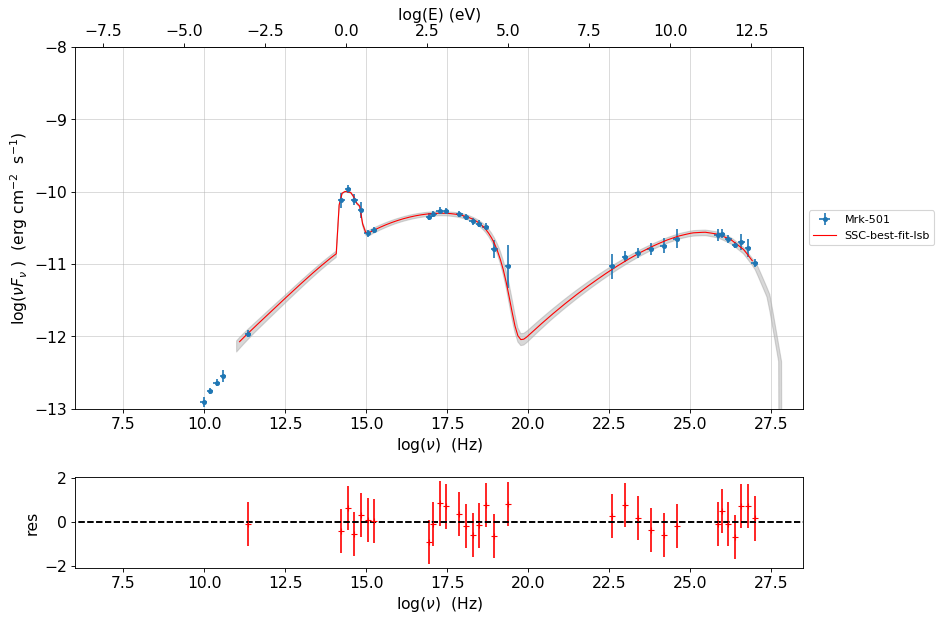

In [18]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[11., 27.],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

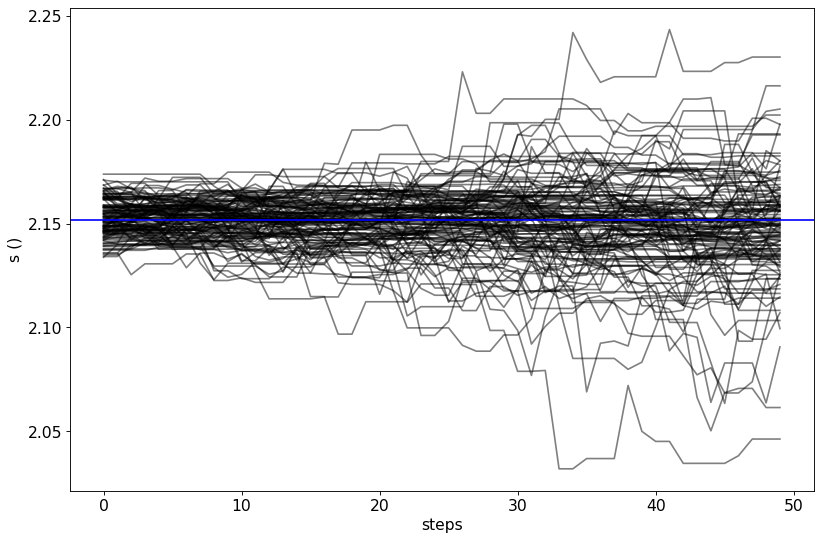

In [19]:
f=mcmc.plot_chain('s',log_plot=False)

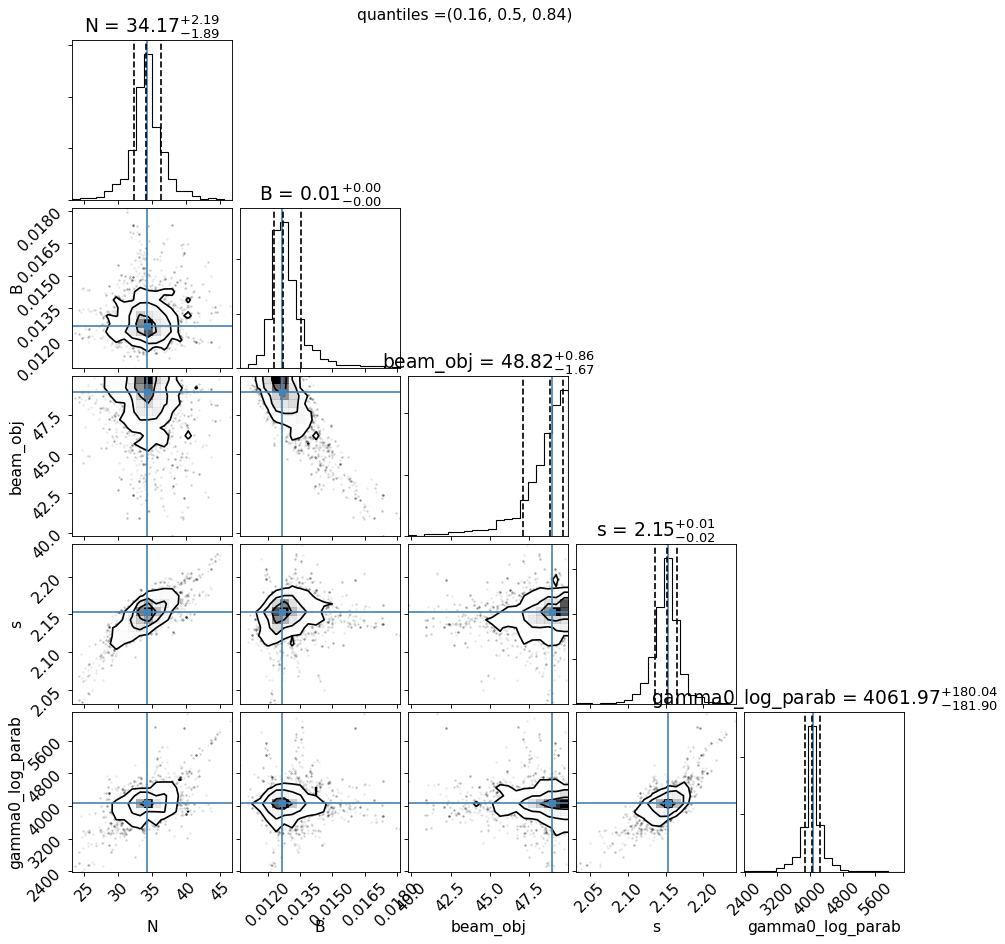

In [20]:
f=mcmc.corner_plot()

In [21]:
mcmc.get_par('N')

(array([33.62965681, 33.03731839, 33.64361785, ..., 29.52744229,
        41.31820058, 39.60121389]),
 0)

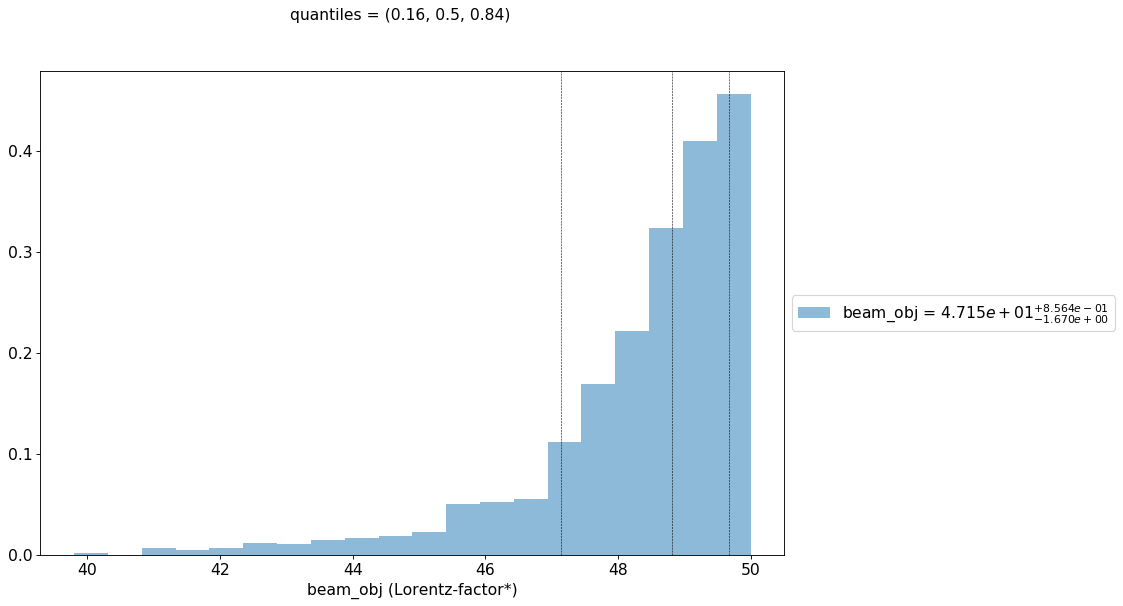

In [22]:
f=mcmc.plot_par('beam_obj')

The posterior of the beaming factor is clearly truncated, so we should rerun the fit changing the constrain on `beam_obj` parameter.

In [29]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)


      name             par type           units          val      phys. bound. min phys. bound. max  log  frozen
---------------- ------------------- --------------- ------------ ---------------- ---------------- ----- ------
            gmin  low-energy-cut-off lorentz-factor* 1.057074e+02     1.000000e+00     1.000000e+09 False  False
            gmax high-energy-cut-off lorentz-factor* 1.642067e+06     1.000000e+00     1.000000e+15 False  False
               N    emitters_density         1 / cm3 1.078494e+02     0.000000e+00               -- False  False
               s   LE_spectral_slope                 2.248787e+00    -1.000000e+01     1.000000e+01 False  False
               r  spectral_curvature                 3.205572e-01    -1.500000e+01     1.500000e+01 False  False
gamma0_log_parab    turn-over-energy lorentz-factor* 7.432066e+03     1.000000e+00     1.000000e+09 False  False
               R         region_size              cm 5.485641e+15     1.000000e+03     1.000000e

In [35]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 


In [36]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 100.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [37]:
model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3,silent=True)

fit run: 0

fit run: 1

fit run: 2


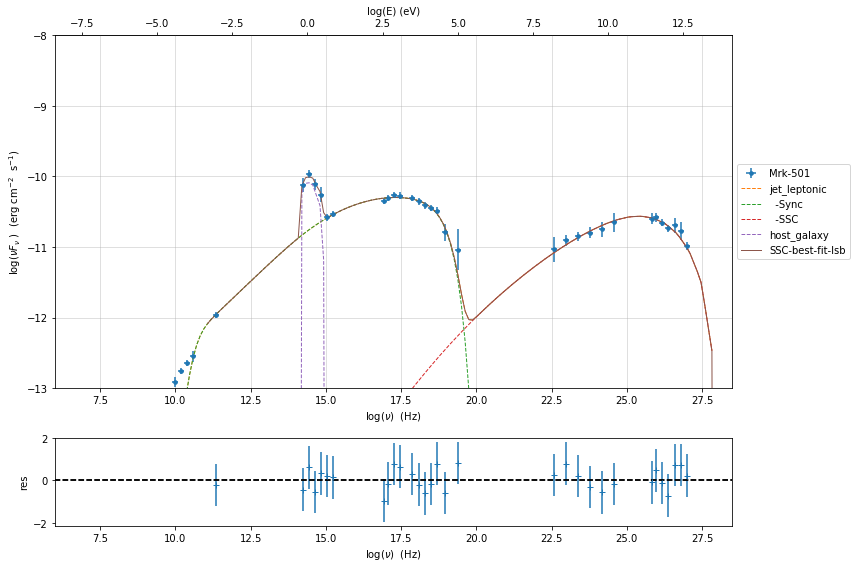

In [38]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [39]:
best_fit_lsb.save_report('SSC-best-fit-lsb.txt')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

In [40]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting


100%|██████████| 50/50 [06:02<00:00,  7.24s/it]

mcmc run done, with 1 threads took 369.33 seconds


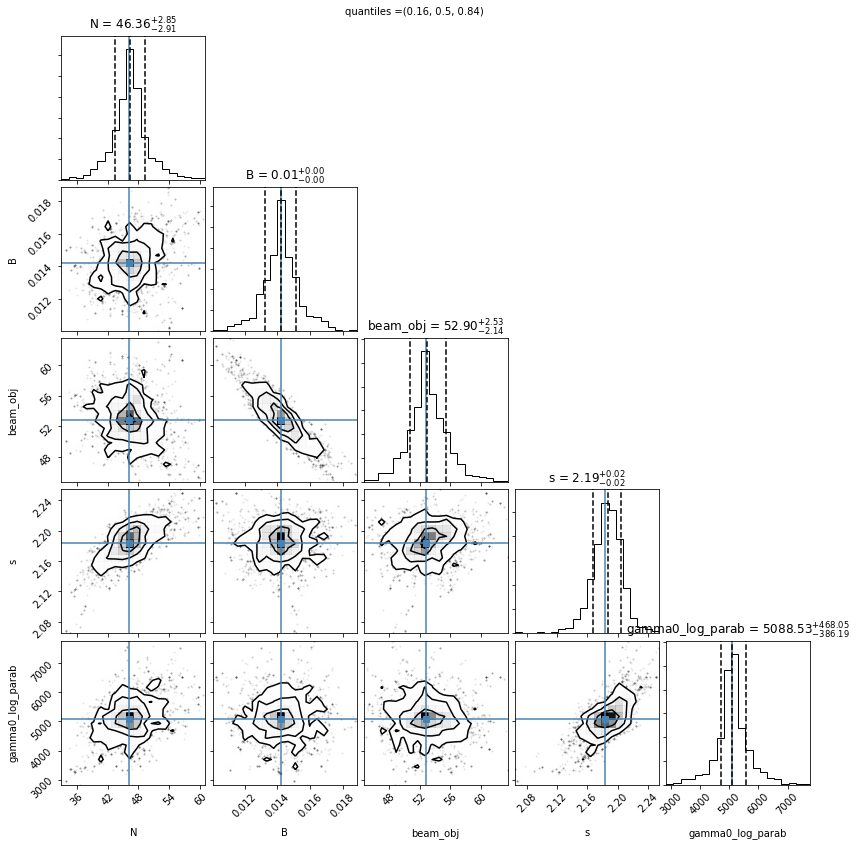

In [41]:
f=mcmc.corner_plot()

## Save and reuse MCMC

In [42]:
mcmc.save('mcmc_sampler.pkl')

In [43]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_501.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

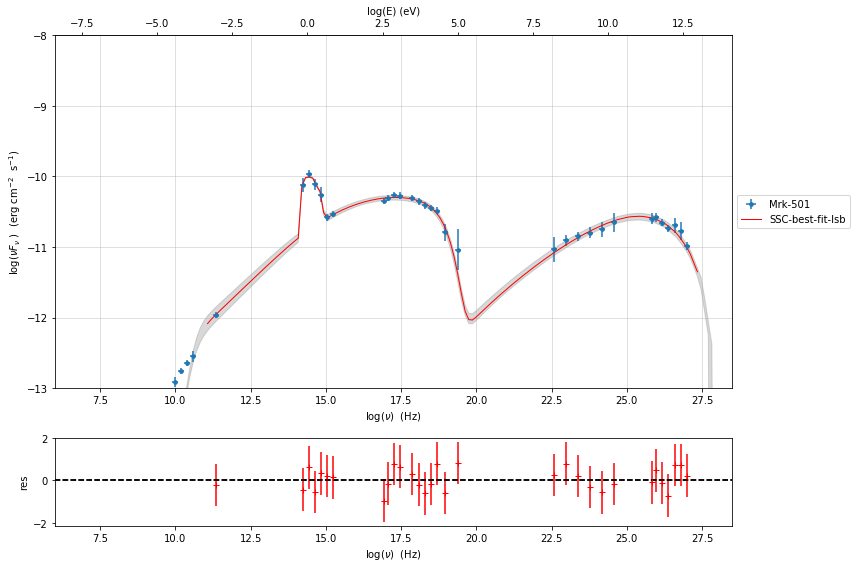

In [44]:
p=ms.plot_model(sed_data=sed_data,fit_range=[11., 27.4],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

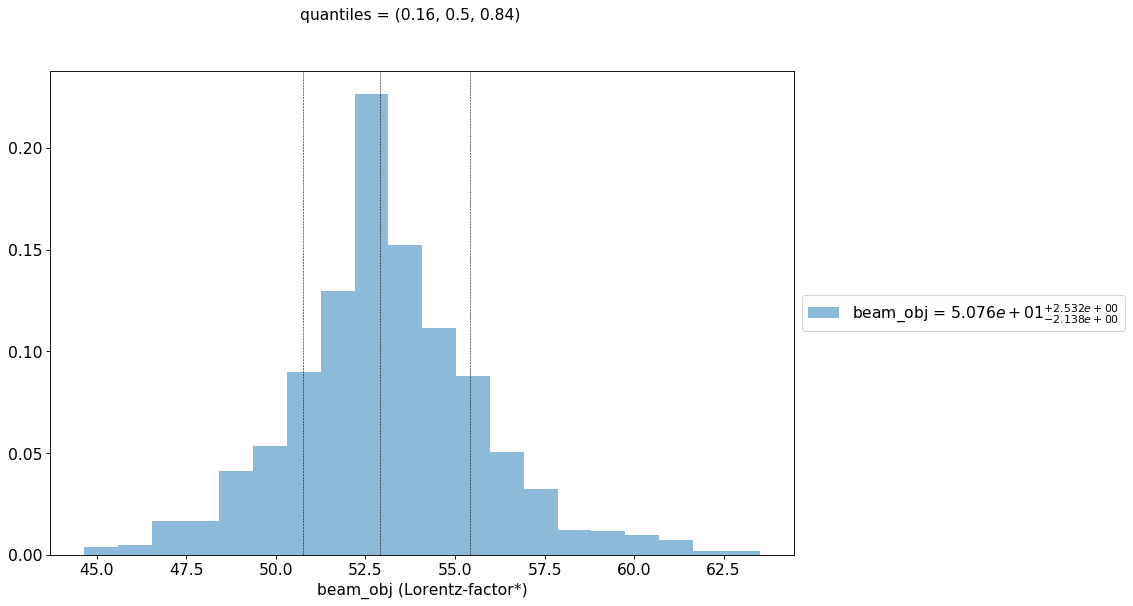

In [45]:
f=ms.plot_par('beam_obj',log_plot=False)


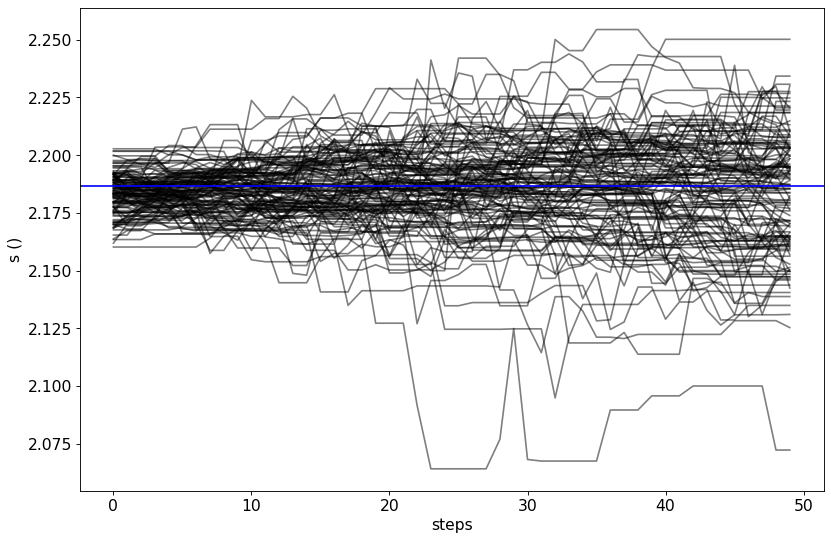

In [46]:
f=ms.plot_chain('s',log_plot=False)